# Tutorial 03: road compliance checking

The collision checker library provides a convenient way to construct the road boundary for a scenario and check if the vehicle is within the road.


## 1. Load the scenario
We import necessary modules and load the example scenario.

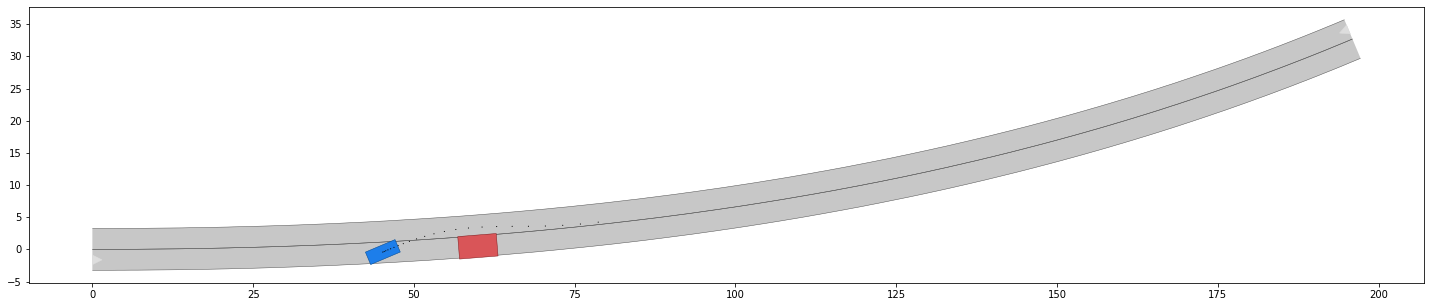

In [1]:
%matplotlib inline
import numpy as np
from time import time
import matplotlib.pyplot as plt

# commonroad
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer


#commonroad_dc
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker
import commonroad_dc.pycrcc as pycrcc



def open_scenario(scenario_filename):

    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set

#open the example scenario
scenario, planning_problem_set = open_scenario("Tut_compliance.xml")


# plot the scenario
rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd)
planning_problem_set.draw(rnd)
rnd.render()


## 2. Build the road boundary

The drivability checker library provides several methods to check road compliance. In particular, methods for the following
two general approaches are implemented:
* **Road boundary collision check (see Section 2.1.)**: checks whether the ego vehicle trajectory collides with the boundary, which is approximated using simple shapes.
* **Occupancy inclusion (see Section 2.2.)**: checks whether the ego vehicle occupancy is included within the drivable road network for the entire trajectory.

Both approaches to check road compliance are complementary to each other. Our toolbox provides different methods for each approach,
which might differ in their performance. We demonstrate the methods in the follwing two sections.


### 2.1. Road Boundary Collision Check
The road boundary can be approximated using either triangulation (Section 2.1.1. - 2.1.3.) or oriented rectangles (Section 2.1.4.).

### 2.1.1. Delaunay Triangulation

Computation time: 1.4326281547546387
Number of boundary elements: 1161


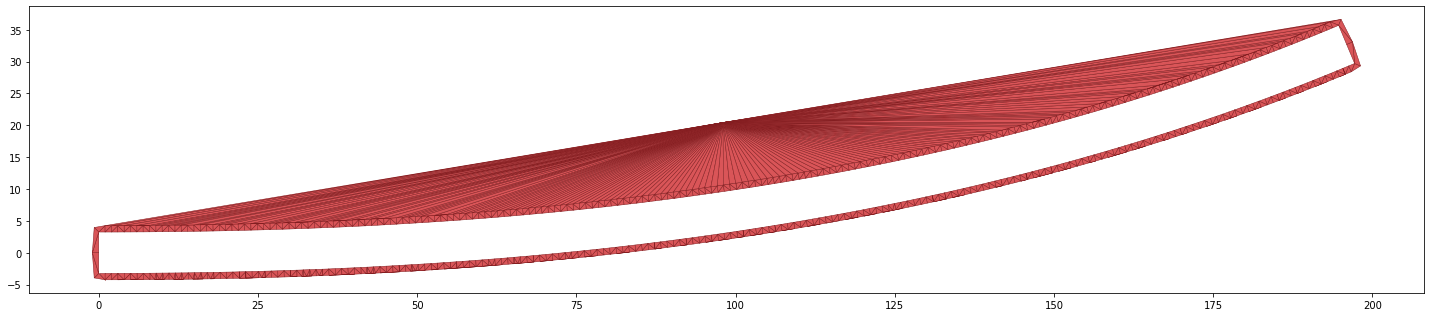

In [2]:
time1=time()
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_triangles.draw(rnd)
rnd.render()
print("Number of boundary elements: %s" % road_boundary_sg_triangles.size())


### 2.1.2. Axis-Aligned Triangles (Horizontal)

Computation time: 0.9591033458709717
Number of boundary elements: 920


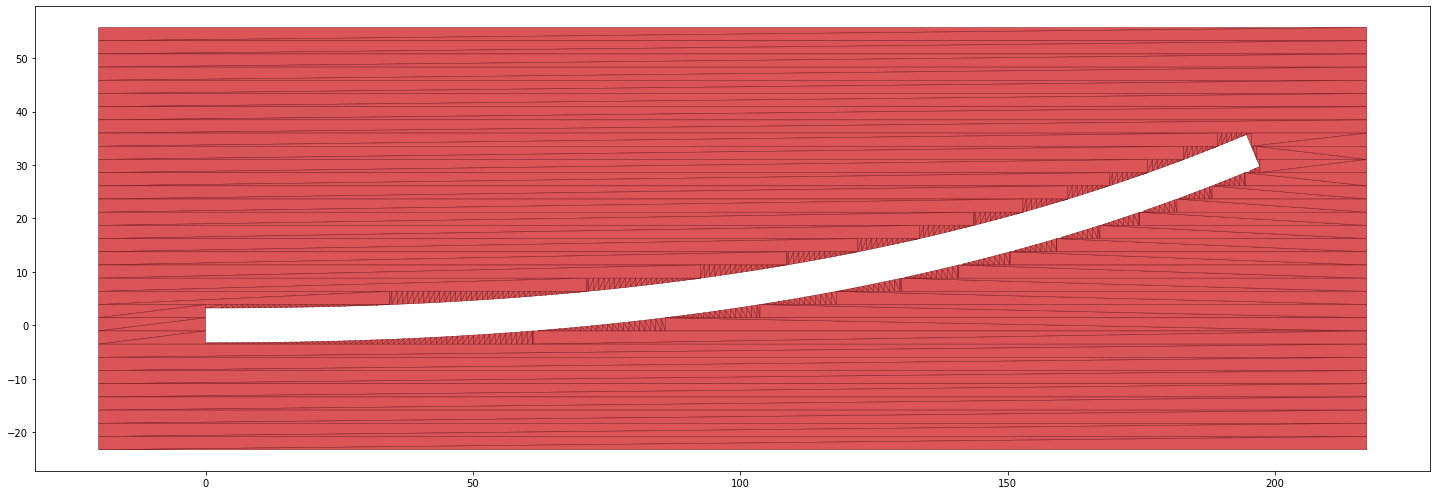

In [3]:
time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=1)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_aligned_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_aligned_triangles.size())


### 2.1.3. Axis-Aligned Triangles (Vertical)

Computation time: 0.927814245223999
Number of boundary elements: 960


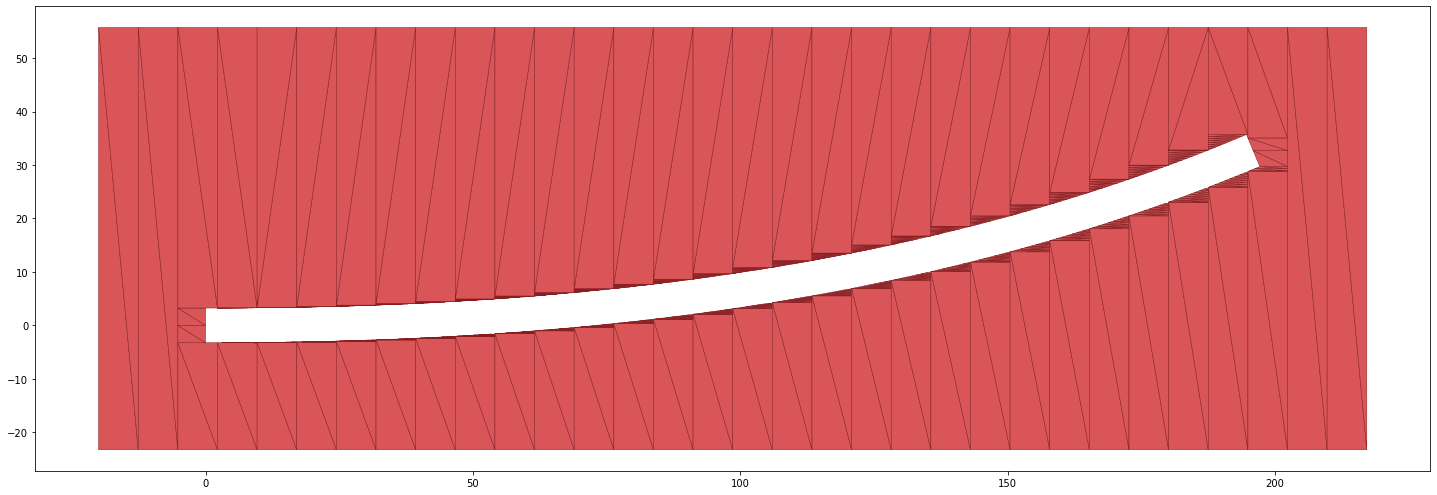

In [4]:
time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=2)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_aligned_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_aligned_triangles.size())


### 2.1.4. Oriented Rectangles

Computation time: 0.047829389572143555
Number of boundary elements: 400


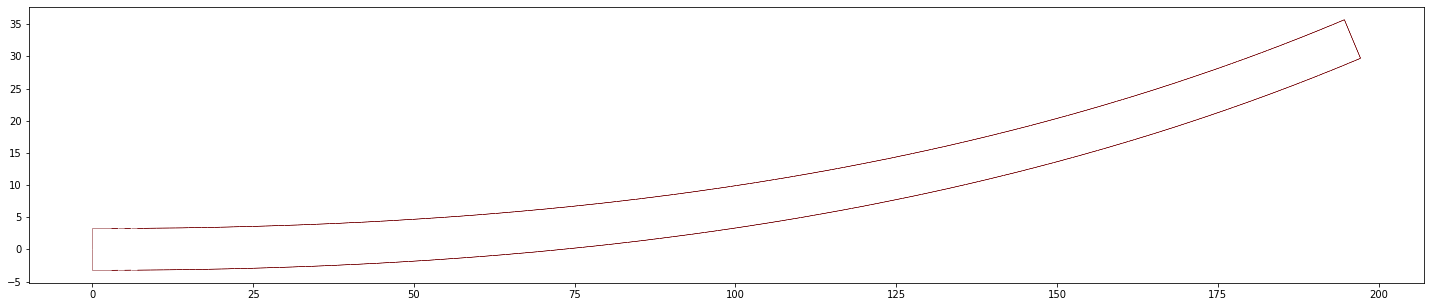

In [5]:
time1=time()
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_rectangles.draw(rnd)
rnd.render()


print("Number of boundary elements: %s" % road_boundary_sg_rectangles.size())


## 2.2. Occupancy Inclusion
The occupancy inclusion approach represents the drivable road network by a set of polygons. Three different methods are
available to construct the polygons.

### 2.2.1. Lane Polygons

Computation time: 0.018321990966796875


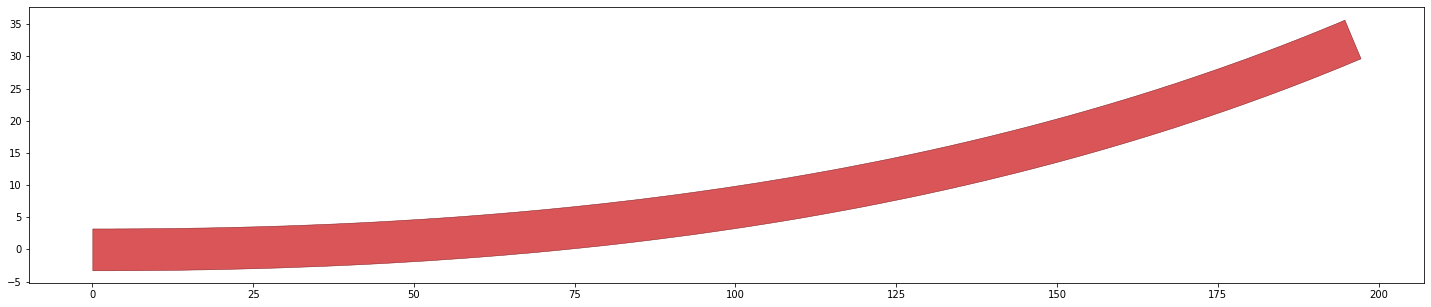

In [20]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='lane_polygons',buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()


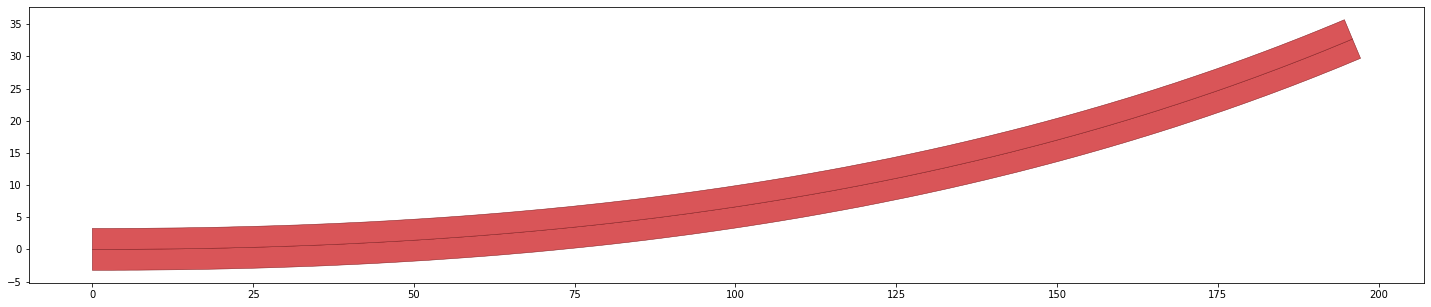

In [21]:
from time import time
from commonroad_dc.boundary import boundary
time1=time()
road_boundary_sg_polygons =boundary.create_road_polygons(scenario, method='lanelet_polygons', buffer=1,resample=1, triangulate=False)
time2=time()

rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()


### 2.2.2. Polygons with Holes (Grid)

Computation time: 0.04476284980773926


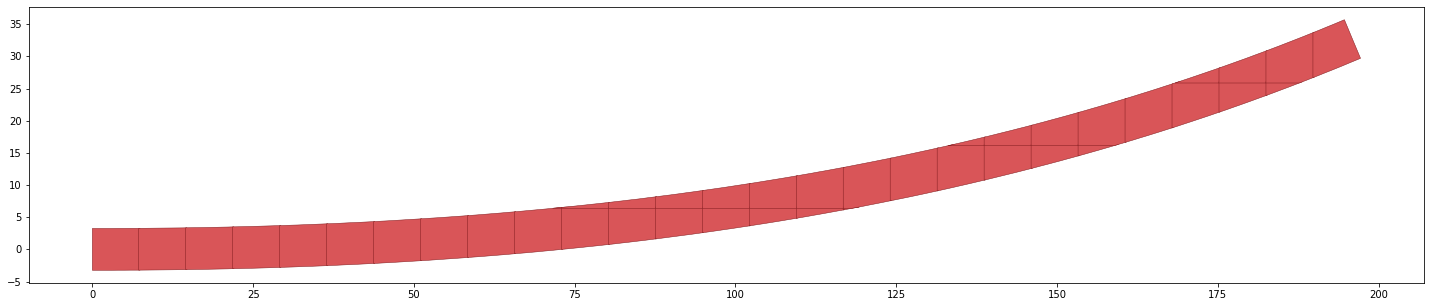

In [7]:
# length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

time1=time()
road_boundary_sg_polygons_grid=boundary.create_road_polygons(scenario, method='whole_polygon_tiled', max_cell_width=car_half_length*3, max_cell_height=car_half_length*5,triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons_grid.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()

### 2.2.3. Polygons with Holes

ERROR:root:Value for key ('shape_group', 'collision', 'polygon', 'draw_mesh') not found!


Computation time: 0.002877950668334961


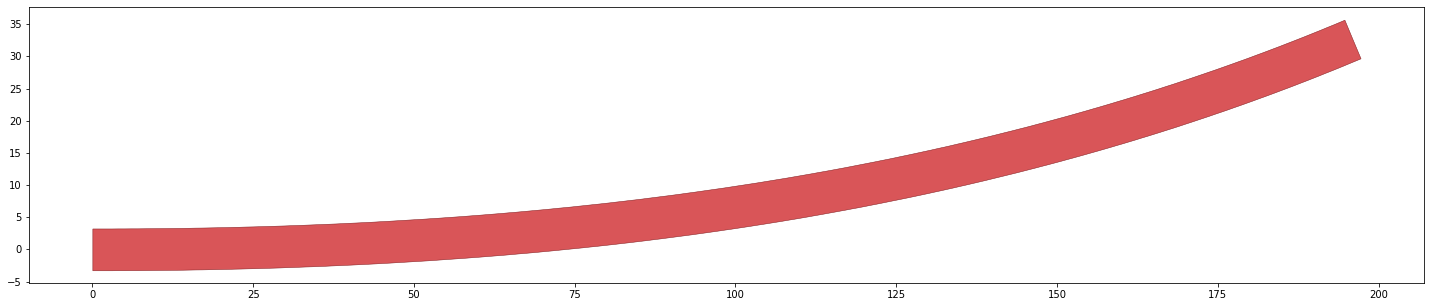

In [8]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons.draw(rnd)
rnd.render()

## 3. Check if the trajectory is within the road

After constructing a road boundary, we can check whether a given trajectory is road-compliant.

### 3.1. Select part of the trajectory for compliance checks

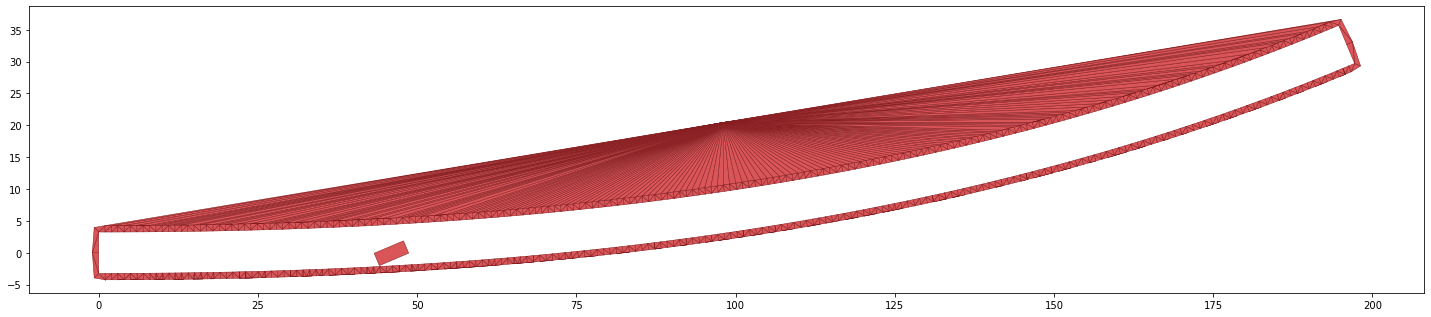

In [24]:
start_step=3

# half-length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# half-width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

# list with trajectory states that are checked for collisions with the road boundary
traj_list=list()
state_list=scenario.dynamic_obstacles[0].prediction.trajectory.state_list

# extract the positions (x,y) and orientation of the state list and store them in traj_list
for el in state_list[start_step:]:
    new_el=list()
    new_el.append(el.position[0])   # position x
    new_el.append(el.position[1])   # position y
    new_el.append(el.orientation)   # orientation
    traj_list.append(new_el)
    
# create an oriented rectangle (RectOBB) for the ego vehicle at Step i of the traj_list
i=0
obb=pycrcc.RectOBB(car_half_length, car_half_width, traj_list[i][2],traj_list[i][0],traj_list[i][1])

# draw the road boundary (here using triangulation) and the ego vehicle at time step i
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_triangles.draw(rnd)
obb.draw(rnd)
rnd.render()


We create a time-variant collision object for the ego vehicle.

In [25]:
def create_tvobstacle(traj_list,car_half_length,car_half_width):
    tvo=pycrcc.TimeVariantCollisionObject(0)
    for traj in traj_list:
        tvo.append_obstacle(pycrcc.RectOBB(car_half_length, car_half_width, traj[2],traj[0],traj[1]))
    return tvo

co=create_tvobstacle(traj_list,car_half_length,car_half_width)


Next, we preprocess the time-variant collision object (ego vehicle) for continuous collision detection: We construct an oriented bounding box (OBB)
around the occupancies for two consecutive time steps. The trajectory of the resulting time-variant collision object is one time step
smaller than the original trajectory.

In [26]:
# preprocess using OBB sum hull
preprocessed_trajectory, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
if(err):
    raise Exception("trajectory preprocessing error")


We can then check whether the trajectories are compliant to the road network using the approaches described above:

### Approach 1: Road boundary collision checks

#### Triangulation

In [27]:
# compute time step of collision with road boundary using traingulation
ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], road_boundary_sg_aligned_triangles, method='grid', num_cells=32, auto_orientation=True)
if ret[0] == -1:
    print('No collision')
else:
    print('First time step of collision: %s' % ret[0])

No collision


#### Oriented Rectangles

In [28]:
# compute time step of collision with road boundary using oriented rectangles
ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)
if ret[0] == -1:
    print('No collision')
else:
    print('First time step of collision: %s' % ret[0])


No collision


### Approach 2: Occupancy Inclusion

#### Polygons with holes (grid)

In [29]:
# check trajectory enclosure using road polygon
ret=trajectory_queries.trajectories_enclosure_polygons_static([preprocessed_trajectory], road_boundary_sg_polygons_grid, method='grid', num_cells=32, enable_verification=False)
if ret[0] == -1:
    print('Trajectory completely enclosed')
else:
    print('First time step of incomplete enclosure: %s' % ret[0])


Trajectory completely enclosed


## 4. Minkowski sum for road boundary

As demonstrated in *Tutorial 02: CommonRoad Interface*, our toolbox allows us to compute the minkowski sum with a circle
for any *commonroad-io* shape. The same can be done for the road boundary obstacle when using approach 1 for road compliance
checking. As shown below, we can inflate the road boundary obstacle which corresponds to specifying a safety distance
the vehicle should keep to the road boundary.


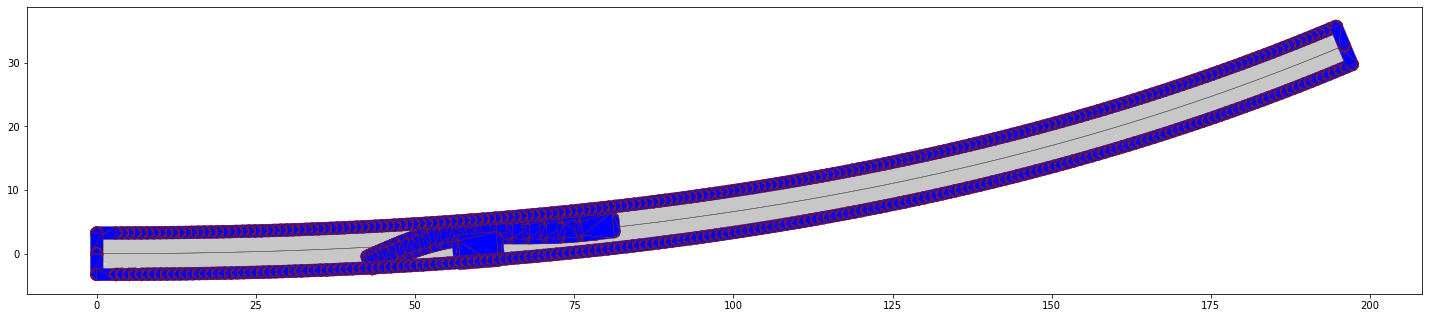

In [30]:
# create road boundary obstacle (here using oriented rectangles)
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles')

# add road boundary as static obstacle to scenario
scenario.add_objects(road_boundary_obstacle)

# create collision checker for scenario
cc = create_collision_checker(scenario, params={'minkowski_sum_circle': True,
                                                'minkowski_sum_circle_radius': 1.0,
                                                'resolution': 4})

# visualize scenario and collision objects
rnd = MPRenderer(figsize=(25, 10))
scenario.lanelet_network.draw(rnd)
cc.draw(rnd, draw_params={'facecolor': 'blue', 'draw_mesh': True})
rnd.render()